In [121]:
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 1000)
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [81]:
#importing data
df = pd.read_csv('clean_df.csv')

#making copy to work with
df_copy = df.copy()

X = df_copy.drop(['NEXT_MONTH_DEFAULT','Client_ID'], axis=1)
y = df_copy["NEXT_MONTH_DEFAULT"]

#splitting training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test

Counter({0: 18286, 1: 5194})


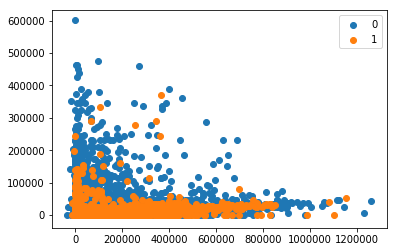

In [93]:
# Generate and plot a synthetic imbalanced classification dataset
from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where
# summarize class distribution
counter = Counter(y)
print(counter)
# scatter plot of examples by class label
for label, _ in counter.items():
	row_ix = where(y == label)[0]
	pyplot.scatter(X.iloc[row_ix, 11:12], X.iloc[row_ix,17], label=str(label))
pyplot.legend()
pyplot.show()

In [117]:
# define model
model = XGBClassifier()
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
# summarize performance
print('"Accuracy: %.5f' % mean(scores))

Mean ROC AUC: 0.81911


In [118]:
# define model
model = XGBClassifier(scale_pos_weight=99)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# evaluate model
scores = cross_val_score(model, X, y, cv=cv, n_jobs=-1)
# summarize performance
print('"Accuracy: %.5f' % mean(scores))

Mean ROC AUC: 0.22792


In [119]:
# grid search positive class weights with xgboost for imbalance classification
from numpy import mean
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from xgboost import XGBClassifier

# define model
model = XGBClassifier()
# define grid
weights = [1, 10, 25, 50, 75, 99, 100, 1000]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv)
# execute the grid search
grid_result = grid.fit(X, y)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.819108 using {'scale_pos_weight': 1}
0.819108 (0.004939) with: {'scale_pos_weight': 1}
0.449546 (0.011866) with: {'scale_pos_weight': 10}
0.262422 (0.004551) with: {'scale_pos_weight': 25}
0.233745 (0.003040) with: {'scale_pos_weight': 50}
0.229259 (0.002503) with: {'scale_pos_weight': 75}
0.227924 (0.002325) with: {'scale_pos_weight': 99}
0.227683 (0.002334) with: {'scale_pos_weight': 100}
0.225028 (0.001367) with: {'scale_pos_weight': 1000}


In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)
# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

"Accuracy: 0.81911


In [123]:
import xgboost as xgb
data_dmatrix = xgb.DMatrix(data=X,label=y)
xg_reg = xgb.XGBRegressor(objective ='reg:logistic', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 10)
# evaluate model
scores = cross_val_score(xg_reg, X, y, cv=cv, n_jobs=-1)
# summarize performance
print('"Accuracy: %.5f' % mean(scores))

C:\ProgramData\Miniconda3\envs\sample1\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\ProgramData\Miniconda3\envs\sample1\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


"Accuracy: 0.10092


In [129]:
X_train.shape
X_test.shape

(7044, 25)

In [134]:
#!/usr/bin/python
import numpy as np
import scipy.sparse
import pickle
import xgboost as xgb
 
### simple example
# load file from text file, also binary buffer generated by xgboost
dtrain = xgb.DMatrix(X_train,label=y_train)
dtest = xgb.DMatrix(X_test,label=y_test)

# specify parameters via map, definition are same as c++ version
param = {'max_depth':2, 'eta':1, 'silent':1, 'objective':'binary:logistic'}

# specify validations set to watch performance
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 2
bst = xgb.train(param, dtrain, num_round, watchlist)

# this is prediction
preds = bst.predict(dtest)
labels = dtest.get_label()
print('error=%f' % (sum(1 for i in range(len(preds)) if int(preds[i] > 0.5) != labels[i]) / float(len(preds))))
bst.save_model('0001.model')
# dump model
bst.dump_model('dump.raw.txt')
# dump model with feature map
bst.dump_model('dump.nice.txt', '../data/featmap.txt')

# save dmatrix into binary buffer
dtest.save_binary('dtest.buffer')
# save model
bst.save_model('xgb.model')
# load model and data in
bst2 = xgb.Booster(model_file='xgb.model')
dtest2 = xgb.DMatrix('dtest.buffer')
preds2 = bst2.predict(dtest2)
# assert they are the same
assert np.sum(np.abs(preds2 - preds)) == 0

# alternatively, you can pickle the booster
pks = pickle.dumps(bst2)
# load model and data in
bst3 = pickle.loads(pks)
preds3 = bst3.predict(dtest2)
# assert they are the same
assert np.sum(np.abs(preds3 - preds)) == 0

###
# build dmatrix from scipy.sparse
print('start running example of build DMatrix from scipy.sparse CSR Matrix')
labels = []
row = []; col = []; dat = []
i = 0
for l in open('../data/agaricus.txt.train'):
    arr = l.split()
    labels.append(int(arr[0]))
    for it in arr[1:]:
        k,v = it.split(':')
        row.append(i); col.append(int(k)); dat.append(float(v))
    i += 1
csr = scipy.sparse.csr_matrix((dat, (row, col)))
dtrain = xgb.DMatrix(csr, label=labels)
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, watchlist)

print('start running example of build DMatrix from scipy.sparse CSC Matrix')
# we can also construct from csc matrix
csc = scipy.sparse.csc_matrix((dat, (row, col)))
dtrain = xgb.DMatrix(csc, label=labels)
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, watchlist)

print('start running example of build DMatrix from numpy array')
# NOTE: npymat is numpy array, we will convert it into scipy.sparse.csr_matrix in internal implementation
# then convert to DMatrix
npymat = csr.todense()
dtrain = xgb.DMatrix(npymat, label=labels)
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
bst = xgb.train(param, dtrain, num_round, watchlist)

[0]	eval-error:0.181573	train-error:0.182222
[1]	eval-error:0.184412	train-error:0.181553
error=0.184412
[09:52:40] 7044x25 matrix with 176100 entries loaded from dtest.buffer
start running example of build DMatrix from scipy.sparse CSR Matrix


FileNotFoundError: [Errno 2] No such file or directory: '../data/agaricus.txt.train'

In [136]:
import xgboost as xgb
import pandas as pd

def get_xgb_feat_importances(clf):

    if isinstance(clf, xgb.XGBModel):
        # clf has been created by calling
        # xgb.XGBClassifier.fit() or xgb.XGBRegressor().fit()
        fscore = clf.booster().get_fscore()
    else:
        # clf has been created by calling xgb.train.
        # Thus, clf is an instance of xgb.Booster.
        fscore = clf.get_fscore()

    feat_importances = []
    for ft, score in fscore.iteritems():
        feat_importances.append({'Feature': ft, 'Importance': score})
    feat_importances = pd.DataFrame(feat_importances)
    feat_importances = feat_importances.sort_values(
        by='Importance', ascending=False).reset_index(drop=True)
    # Divide the importances by the sum of all importances
    # to get relative importances. By using relative importances
    # the sum of all importances will equal to 1, i.e.,
    # np.sum(feat_importances['importance']) == 1
    feat_importances['Importance'] /= feat_importances['Importance'].sum()
    # Print the most important features and their importances
    print(feat_importances.head())
    return feat_importances

In [6]:
#importing test data
Test = pd.read_csv('TestData.csv')

#making copy to work with
Test_copy = Test.copy()

Test_copy= Test_copy.drop(['Client_ID'], axis=1)

#Train the model using the complete training set using the model parameters defined above
clf.fit(X, y)

#predicting values for test set
y_pred=clf.predict(Test_copy)

#Create a  DataFrame with the client ids and our prediction 
submission = pd.DataFrame({'Client_ID':Test['Client_ID'],'NEXT_MONTH_DEFAULT':y_pred})

#Convert DataFrame to a csv file that can be uploaded
filename = 'Predictions AdaBooster  0.8162.csv'

submission.to_csv(filename,index=False)

print('Saved file: ' + filename)

Saved file: Predictions AdaBooster  0.8162.csv
